Ticker selections
=================

In [1]:
# If you would like to refresh your data, please execute the bellow codes.

import pandas as pd
from datetime import datetime
from tqdm import tqdm

from mypo import Loader

DOWNLOAD = False

if DOWNLOAD:
    tickers = pd.read_csv("/app/docs/tutorial/tickers.csv")
    loader = Loader()
    for row in tqdm(tickers.to_dict('record')):
        loader.get(row['Ticker'], expense_ratio=row['ExpenseRatio'] * 0.01)
    loader.save('/app/docs/tutorial/all.bin')

In [2]:
loader = Loader.load('/app/docs/tutorial/all.bin')
loader = loader.since(datetime(2005, 1, 1))
market = loader.get_market()

In [3]:
pd.set_option('display.max_rows', 200)

summary = loader.summary()
summary = summary.sort_index()
summary

,established,names,total_assets,volume,expense_ratio
AGG,2003-09-29,iShares Core U.S. Aggregate Bond ETF,85938724864,6466483,0.0005
BBH,1999-11-23,VanEck Vectors Biotech ETF,495472128,6928,0.0035
DIA,1998-01-20,SPDR Dow Jones Industrial Average ETF Trust,25793642496,4995800,0.0016
DVY,2003-11-07,iShares Select Dividend ETF,15882481664,1065285,0.0039
EEM,2003-04-14,iShares MSCI Emerging Markets ETF,29338421248,65868433,0.0070
EFA,2001-08-27,iShares MSCI EAFE ETF,53298008064,24144216,0.0032
EPP,2001-10-26,iShares MSCI Pacific ex Japan ETF,2290522112,271300,0.0048
EWG,1996-03-18,iShares MSCI Germany ETF,2596413952,3059500,0.0051
EWJ,1996-03-18,iShares MSCI Japan ETF,13236024320,6636166,0.0051
EWM,1996-03-18,iShares MSCI Malaysia ETF,380267392,300166,0.0051


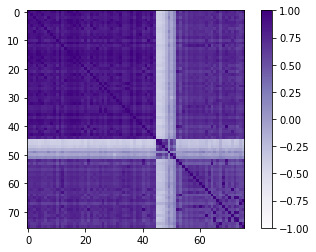

,DIA,VBK,VAW,VUG,VTV,IJR,XLK,XLB,XLI,IOO,...,VDC,XLU,ILF,XLV,XLE,RWR,IXC,OIH,VPU,XLP
DIA,1.000000,0.869771,0.859922,0.929926,0.958851,0.866318,0.888003,0.847780,0.923129,0.938661,...,0.851901,0.687816,0.767659,0.822007,0.767047,0.731212,0.790183,0.673832,0.719169,0.806004
VBK,0.869771,1.000000,0.877067,0.927276,0.888985,0.948652,0.856504,0.845448,0.871164,0.871222,...,0.739583,0.585509,0.750748,0.762026,0.736024,0.742433,0.749881,0.682318,0.626350,0.681020
VAW,0.859922,0.877067,1.000000,0.857148,0.881565,0.863043,0.778800,0.979438,0.875534,0.860293,...,0.713131,0.597504,0.801516,0.691176,0.806604,0.689068,0.821532,0.747929,0.633524,0.657361
VUG,0.929926,0.927276,0.857148,1.000000,0.906242,0.858485,0.947440,0.840877,0.875607,0.931639,...,0.813619,0.642346,0.763365,0.821977,0.726572,0.702638,0.749901,0.649599,0.674983,0.763365
VTV,0.958851,0.888985,0.881565,0.906242,1.000000,0.900183,0.847667,0.859418,0.919426,0.935172,...,0.838729,0.701510,0.779995,0.806847,0.793475,0.794066,0.809794,0.703712,0.735186,0.791998
IJR,0.866318,0.948652,0.863043,0.858485,0.900183,1.000000,0.796108,0.827230,0.881274,0.840896,...,0.741441,0.580604,0.727546,0.717123,0.743758,0.768430,0.749193,0.699281,0.624710,0.685955
XLK,0.888003,0.856504,0.778800,0.947440,0.847667,0.796108,1.000000,0.765053,0.812140,0.885974,...,0.754542,0.585883,0.705930,0.743462,0.646347,0.646965,0.672595,0.573720,0.614441,0.712980
XLB,0.847780,0.845448,0.979438,0.840877,0.859418,0.827230,0.765053,1.000000,0.865323,0.845856,...,0.705967,0.589035,0.782982,0.694629,0.786435,0.662814,0.802208,0.723650,0.621970,0.657360
XLI,0.923129,0.871164,0.875534,0.875607,0.919426,0.881274,0.812140,0.865323,1.000000,0.876364,...,0.769169,0.610453,0.737309,0.749752,0.744118,0.718018,0.765819,0.684192,0.646028,0.726137
IOO,0.938661,0.871222,0.860293,0.931639,0.935172,0.840896,0.885974,0.845856,0.876364,1.000000,...,0.817936,0.662040,0.797623,0.799246,0.768566,0.710299,0.814352,0.679449,0.692349,0.771692


In [4]:
import matplotlib.pyplot as plt
from mypo import clustering_tickers, evaluate_combinations
cluster = clustering_tickers(market, n=4)
corr = market.get_rate_of_change()[cluster.index].corr()

plt.figure()
plt.imshow(corr,interpolation='nearest',vmin=-1,vmax=1,cmap='Purples')
plt.colorbar()
plt.show()

corr

In [5]:
from mypo import split_n_periods
from mypo.optimizer import MinimumVarianceOptimizer
from mypo.indicator import yearly_total_return, max_drawdown, max_drawdown_span
from mypo.rebalancer import MonthlyRebalancer
from mypo import Runner

trains, evals = split_n_periods(market, 5, 200)

  1%|          | 7/583 [00:00<00:09, 63.94it/s]

                         c         r         q  sharp ratio
9524  [EPP, TLT, GLD, IXC]  0.000521  0.000020    25.736610
9505  [EPP, TLT, GLD, BBH]  0.000518  0.000020    26.357671
3457  [EEM, TLT, GLD, BBH]  0.000515  0.000020    25.919526
9519  [EPP, TLT, GLD, XLU]  0.000510  0.000019    26.206502
9526  [EPP, TLT, GLD, VPU]  0.000507  0.000020    25.964359
3476  [EEM, TLT, GLD, IXC]  0.000504  0.000021    24.438764
9510  [EPP, TLT, GLD, EWW]  0.000502  0.000020    24.884705
9522  [EPP, TLT, GLD, XLE]  0.000502  0.000020    24.608404
9525  [EPP, TLT, GLD, OIH]  0.000498  0.000020    24.479251
9517  [EPP, TLT, GLD, VDE]  0.000495  0.000020    24.207372


100%|██████████| 583/583 [00:07<00:00, 81.81it/s]


[0.1423237  0.69229581 0.06138576 0.10399473]
1.1470321597027393
0.9115823020854461
102


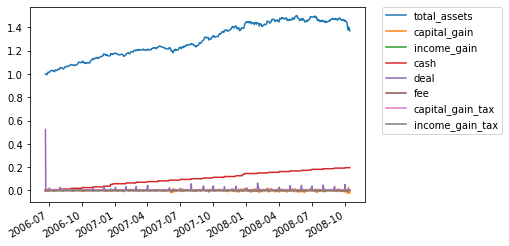

  1%|          | 7/583 [00:00<00:08, 67.30it/s]

                           c         r         q  sharp ratio
8785   [SPTM, SHY, GLD, BBH]  0.000158  0.000002    66.001901
3049    [XLF, SHY, AGG, BBH]  0.000155  0.000002    75.267060
9097    [DVY, SHY, AGG, BBH]  0.000152  0.000002    71.929477
3025    [XLF, SHY, GLD, BBH]  0.000152  0.000002    74.218053
9073    [DVY, SHY, GLD, BBH]  0.000151  0.000002    71.656670
12265   [VFH, SHY, AGG, BBH]  0.000150  0.000002    73.423391
8803   [SPTM, SHY, GLD, RWR]  0.000150  0.000002    62.584329
12241   [VFH, SHY, GLD, BBH]  0.000147  0.000002    72.572580
6217    [IXJ, SHY, AGG, BBH]  0.000146  0.000002    61.414623
3073    [XLF, SHY, LQD, BBH]  0.000146  0.000002    71.319316


100%|██████████| 583/583 [00:07<00:00, 83.17it/s]


[1.29055925e-02 9.81667772e-01 4.33680869e-19 5.42663531e-03]
1.0365529193655894
0.9937746874179553
44


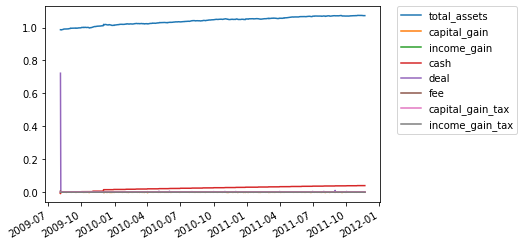

  1%|          | 7/583 [00:00<00:08, 68.88it/s]

                         c         r         q  sharp ratio
289   [VBK, TLT, GLD, BBH]  0.001121  0.000032    35.059727
1441  [IJR, TLT, GLD, BBH]  0.001118  0.000031    35.970719
5185  [IWM, TLT, GLD, BBH]  0.001101  0.000032    34.957192
9505  [EPP, TLT, GLD, BBH]  0.001090  0.000032    34.365814
4609   [VB, TLT, GLD, BBH]  0.001084  0.000031    34.958032
9793  [EWG, TLT, GLD, BBH]  0.001083  0.000031    34.526388
3457  [EEM, TLT, GLD, BBH]  0.001074  0.000031    34.170793
577   [VAW, TLT, GLD, BBH]  0.001069  0.000031    34.051547
1452  [IJR, TLT, GLD, IBB]  0.001059  0.000035    30.511947
6337  [VBR, TLT, GLD, BBH]  0.001058  0.000030    34.959154


100%|██████████| 583/583 [00:07<00:00, 82.32it/s]


[0.32962422 0.52319394 0.14718184 0.        ]
1.11151177691704
0.9302482040176286
116


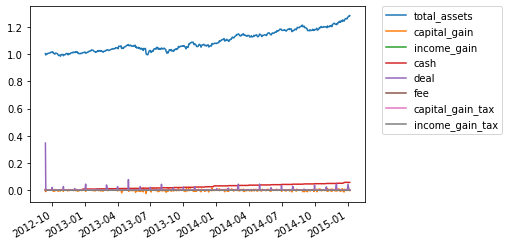

  1%|          | 6/583 [00:00<00:10, 55.30it/s]

                          c         r         q  sharp ratio
11539  [VHT, TLT, GLD, RWR]  0.000866  0.000016    55.209564
11530  [VHT, TLT, GLD, IYR]  0.000843  0.000015    54.803737
5491   [QQQ, TLT, GLD, RWR]  0.000825  0.000014    59.155575
11531  [VHT, TLT, GLD, FXI]  0.000818  0.000016    51.369447
5482   [QQQ, TLT, GLD, IYR]  0.000809  0.000014    58.263252
11535  [VHT, TLT, GLD, XLU]  0.000797  0.000017    47.010604
11521  [VHT, TLT, GLD, BBH]  0.000795  0.000017    45.773166
11532  [VHT, TLT, GLD, IBB]  0.000795  0.000017    45.769378
11542  [VHT, TLT, GLD, VPU]  0.000793  0.000017    46.938599
11537  [VHT, TLT, GLD, XLV]  0.000790  0.000017    45.710211


100%|██████████| 583/583 [00:07<00:00, 82.93it/s]


[0.37077987 0.25688214 0.20889923 0.16343875]
1.0723282352702899
0.8801090990800846
225


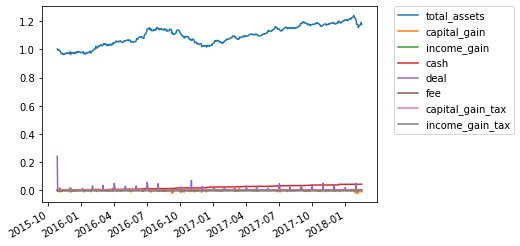

  1%|▏         | 8/583 [00:00<00:07, 73.54it/s]

                       c         r         q  sharp ratio
3   [DIA, TLT, GLD, EWM]  0.000489  0.000013    36.396841
4   [DIA, TLT, GLD, EWS]  0.000481  0.000014    35.086280
12  [DIA, TLT, GLD, IBB]  0.000478  0.000014    34.679695
21  [DIA, TLT, GLD, OIH]  0.000478  0.000014    34.676860
9   [DIA, TLT, GLD, EZA]  0.000477  0.000014    34.665093
20  [DIA, TLT, GLD, IXC]  0.000477  0.000014    34.645895
11  [DIA, TLT, GLD, FXI]  0.000477  0.000014    34.641326
7   [DIA, TLT, GLD, EWY]  0.000477  0.000014    34.641103
1   [DIA, TLT, GLD, BBH]  0.000477  0.000014    34.640267
16  [DIA, TLT, GLD, ILF]  0.000477  0.000014    34.640139


100%|██████████| 583/583 [00:06<00:00, 83.58it/s]


[0.20229627 0.49098431 0.24417897 0.06254045]
1.0995100790592307
0.8303309670302825
164


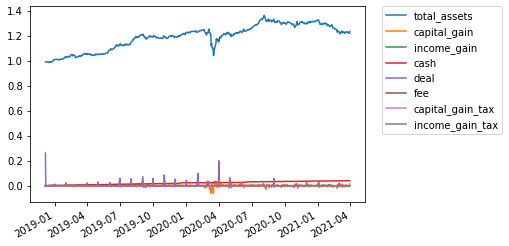

In [6]:
for i in range(len(trains)):
    evaluates = evaluate_combinations(trains[i], cluster, verbose=True)
    del evaluates['w']
    top_10_r = evaluates.sort_values("r", ascending=False).head(10)
    print(top_10_r)
    
    target = evals[i].filter((list(top_10_r['c'])[0]))
    optimizer = MinimumVarianceOptimizer()
    runner = Runner(
        assets=[0.25, 0.25, 0.25, 0.25],
        rebalancer=MonthlyRebalancer(optimizer=optimizer, do_re_optimize=True),
        cash=0
    )

    runner.run(
        market=target,
        train_span=200,
        verbose=True
    )
    report = runner.report()
    print(optimizer.get_weights())
    print(yearly_total_return(report))
    print(max_drawdown(report))
    print(max_drawdown_span(report))
    ax = report.plot()
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    plt.show()

  1%|          | 7/583 [00:00<00:08, 67.90it/s]

                          c         r             q  sharp ratio
11677  [VHT, SHY, GLD, VDE]  0.000089  5.830171e-07   152.756743
11701  [VHT, SHY, AGG, VDE]  0.000089  5.829951e-07   152.688287
11725  [VHT, SHY, LQD, VDE]  0.000089  5.829939e-07   152.473713
11675  [VHT, SHY, GLD, FXI]  0.000087  5.691501e-07   152.113442
11699  [VHT, SHY, AGG, FXI]  0.000086  5.691080e-07   151.966833
11723  [VHT, SHY, LQD, FXI]  0.000086  5.691080e-07   151.965475
11706  [VHT, SHY, AGG, XLE]  0.000088  5.836803e-07   151.593970
11730  [VHT, SHY, LQD, XLE]  0.000088  5.836791e-07   151.385531
11682  [VHT, SHY, GLD, XLE]  0.000088  5.836791e-07   151.382155
11684  [VHT, SHY, GLD, IXC]  0.000088  5.844668e-07   150.861318


100%|██████████| 583/583 [00:07<00:00, 82.31it/s]


[8.26968712e-02 8.94556466e-01 8.67361738e-19 2.27466625e-02]
1.1002355496381273
0.9820350843806681
35


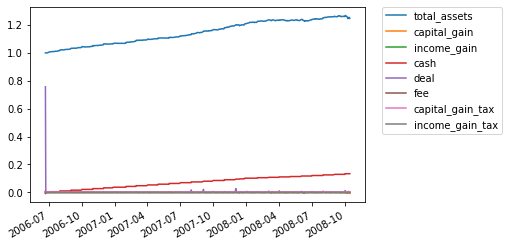

  1%|          | 6/583 [00:00<00:09, 58.50it/s]

                          c         r         q  sharp ratio
3049   [XLF, SHY, AGG, BBH]  0.000155  0.000002    75.267060
3025   [XLF, SHY, GLD, BBH]  0.000152  0.000002    74.218053
12265  [VFH, SHY, AGG, BBH]  0.000150  0.000002    73.423391
12241  [VFH, SHY, GLD, BBH]  0.000147  0.000002    72.572580
9097   [DVY, SHY, AGG, BBH]  0.000152  0.000002    71.929477
9073   [DVY, SHY, GLD, BBH]  0.000151  0.000002    71.656670
3073   [XLF, SHY, LQD, BBH]  0.000146  0.000002    71.319316
9121   [DVY, SHY, LQD, BBH]  0.000143  0.000002    68.085188
3060   [XLF, SHY, AGG, IBB]  0.000139  0.000002    67.987073
12289  [VFH, SHY, LQD, BBH]  0.000135  0.000002    67.367257


100%|██████████| 583/583 [00:07<00:00, 80.03it/s]


[0.00591805 0.98364367 0.         0.01043827]
1.0338145926611644
0.9931662691023454
47


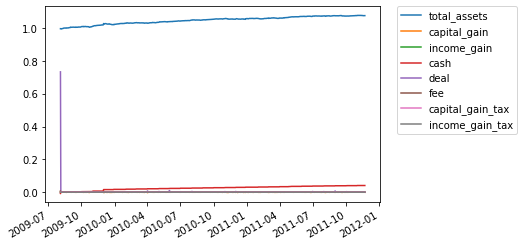

  1%|          | 7/583 [00:00<00:08, 68.61it/s]

                          c         r             q  sharp ratio
12263  [VFH, SHY, GLD, XLP]  0.000091  3.146600e-07   290.360294
5351   [IWM, SHY, GLD, XLP]  0.000091  3.146062e-07   290.191746
455    [VBK, SHY, GLD, XLP]  0.000091  3.145839e-07   290.072755
1607   [IJR, SHY, GLD, XLP]  0.000091  3.145785e-07   290.030756
4775    [VB, SHY, GLD, XLP]  0.000091  3.145735e-07   289.979402
6503   [VBR, SHY, GLD, XLP]  0.000091  3.145717e-07   289.954647
12551  [VXF, SHY, GLD, XLP]  0.000091  3.145688e-07   289.899141
9383   [IJH, SHY, GLD, XLP]  0.000091  3.145677e-07   289.850924
11711  [VHT, SHY, AGG, XLP]  0.000091  3.145435e-07   289.743362
12254  [VFH, SHY, GLD, VDC]  0.000091  3.156368e-07   289.736971


100%|██████████| 583/583 [00:07<00:00, 82.21it/s]


[2.57919458e-02 9.74208054e-01 0.00000000e+00 4.33680869e-19]
1.0077904281992065
0.9962794999921317
63


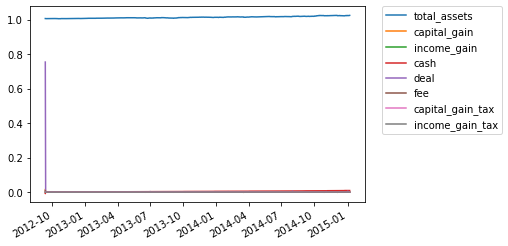

  1%|          | 6/583 [00:00<00:12, 47.35it/s]

                           c         r             q  sharp ratio
3083    [XLF, SHY, LQD, FXI]  0.000044  1.888026e-07   235.488229
3035    [XLF, SHY, GLD, FXI]  0.000044  1.888036e-07   235.105711
12299   [VFH, SHY, LQD, FXI]  0.000044  1.893179e-07   233.823792
3059    [XLF, SHY, AGG, FXI]  0.000044  1.888128e-07   233.761402
12275   [VFH, SHY, AGG, FXI]  0.000044  1.893198e-07   233.281865
12251   [VFH, SHY, GLD, FXI]  0.000044  1.893202e-07   233.250398
8555   [SPYG, SHY, LQD, FXI]  0.000046  1.980188e-07   231.008815
8531   [SPYG, SHY, AGG, FXI]  0.000046  1.980197e-07   230.658928
8507   [SPYG, SHY, GLD, FXI]  0.000046  1.980266e-07   230.118471
8267   [SPYV, SHY, LQD, FXI]  0.000045  1.944986e-07   229.736165


100%|██████████| 583/583 [00:07<00:00, 80.92it/s]


[3.16881565e-02 9.68311844e-01 0.00000000e+00 1.30104261e-18]
1.0152529055940855
0.9953143039741336
63


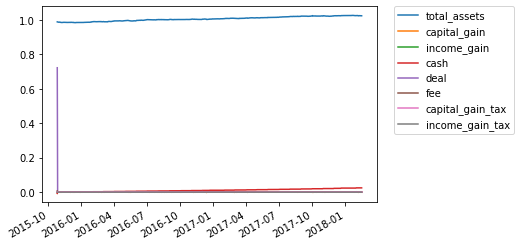

  1%|          | 7/583 [00:00<00:08, 68.90it/s]

                          c         r         q  sharp ratio
12134  [VFH, TLT, AGG, VDC]  0.000086  0.000002    49.343876
12356  [VFH, TIP, AGG, IXC]  0.000086  0.000002    49.292619
12195  [VFH, IEF, AGG, EWM]  0.000086  0.000002    49.291900
12123  [VFH, TLT, AGG, EWM]  0.000086  0.000002    49.224095
2979   [XLF, IEF, AGG, EWM]  0.000089  0.000002    49.206405
12206  [VFH, IEF, AGG, VDC]  0.000086  0.000002    49.195379
12215  [VFH, IEF, AGG, XLP]  0.000086  0.000002    49.169681
12143  [VFH, TLT, AGG, XLP]  0.000086  0.000002    49.167566
12342  [VFH, TIP, AGG, EWW]  0.000086  0.000002    49.156836
12343  [VFH, TIP, AGG, EWY]  0.000086  0.000002    49.150979


100%|██████████| 583/583 [00:07<00:00, 80.22it/s]


[1.30104261e-17 0.00000000e+00 9.41421884e-01 5.85781155e-02]
1.0787403128990471
0.8896012463948555
81


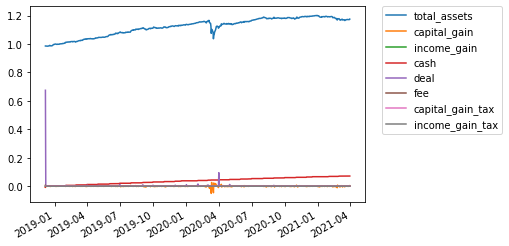

In [7]:
for i in range(len(trains)):
    evaluates = evaluate_combinations(trains[i], cluster, verbose=True)
    del evaluates['w']
    top_10_sharp_ratio = evaluates.sort_values("sharp ratio", ascending=False).head(10)
    print(top_10_sharp_ratio)
    
    target = evals[i].filter((list(top_10_sharp_ratio['c'])[0]))
    optimizer = MinimumVarianceOptimizer()
    runner = Runner(
        assets=[0.25, 0.25, 0.25, 0.25],
        rebalancer=MonthlyRebalancer(optimizer=optimizer, do_re_optimize=True),
        cash=0
    )

    runner.run(
        market=target,
        train_span=200,
        verbose=True
    )
    report = runner.report()
    print(optimizer.get_weights())
    print(yearly_total_return(report))
    print(max_drawdown(report))
    print(max_drawdown_span(report))
    ax = report.plot()
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    plt.show()
    
    
    


  1%|▏         | 8/583 [00:00<00:09, 63.44it/s]

                         c         r             q  sharp ratio
2459  [XLI, SHY, GLD, FXI]  0.000073  5.533717e-07   132.031219
2507  [XLI, SHY, LQD, FXI]  0.000073  5.533745e-07   132.126318
2483  [XLI, SHY, AGG, FXI]  0.000073  5.533941e-07   132.342828
2486  [XLI, SHY, AGG, VDC]  0.000070  5.569885e-07   126.467985
2462  [XLI, SHY, GLD, VDC]  0.000070  5.569909e-07   126.398310
2510  [XLI, SHY, LQD, VDC]  0.000070  5.569977e-07   126.424943
2451  [XLI, SHY, GLD, EWM]  0.000068  5.572625e-07   121.894632
2475  [XLI, SHY, AGG, EWM]  0.000068  5.572638e-07   122.001839
2499  [XLI, SHY, LQD, EWM]  0.000068  5.572739e-07   122.048124
203   [DIA, SHY, LQD, FXI]  0.000076  5.575790e-07   136.951418


100%|██████████| 583/583 [00:07<00:00, 82.05it/s]


[0.04762538 0.93685652 0.         0.0155181 ]
1.1037545834611813
0.9879815835464338
40


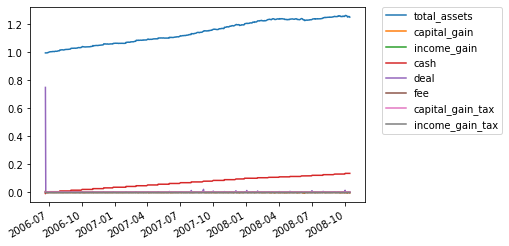

  1%|          | 7/583 [00:00<00:08, 65.68it/s]

                          c         r         q  sharp ratio
1883   [XLK, SHY, GLD, FXI]  0.000076  0.000002    43.571699
10571   [VV, SHY, LQD, FXI]  0.000078  0.000002    44.853372
10547   [VV, SHY, AGG, FXI]  0.000081  0.000002    46.112898
10523   [VV, SHY, GLD, FXI]  0.000081  0.000002    46.555704
1907   [XLK, SHY, AGG, FXI]  0.000078  0.000002    44.440903
1931   [XLK, SHY, LQD, FXI]  0.000079  0.000002    45.136567
11963  [VGT, SHY, GLD, FXI]  0.000078  0.000002    44.112978
3315   [IVV, SHY, GLD, EWM]  0.000057  0.000002    32.513109
3339   [IVV, SHY, AGG, EWM]  0.000057  0.000002    32.565188
3363   [IVV, SHY, LQD, EWM]  0.000057  0.000002    32.387512


100%|██████████| 583/583 [00:07<00:00, 82.37it/s]


[0.01817753 0.98182247 0.         0.        ]
1.0360508089078704
0.993363671630448
79


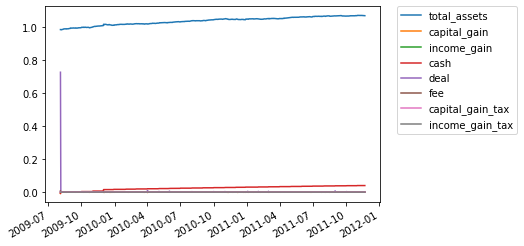

  1%|          | 6/583 [00:00<00:10, 55.39it/s]

                          c         r             q  sharp ratio
7946   [FEZ, SHY, AGG, EWJ]  0.000072  3.035748e-07   237.534287
7970   [FEZ, SHY, LQD, EWJ]  0.000072  3.035761e-07   237.775492
7922   [FEZ, SHY, GLD, EWJ]  0.000072  3.035778e-07   237.969300
7949   [FEZ, SHY, AGG, EWT]  0.000073  3.042651e-07   238.844191
7959   [FEZ, SHY, AGG, XLU]  0.000078  3.042854e-07   255.140299
7925   [FEZ, SHY, GLD, EWT]  0.000073  3.043274e-07   239.934446
8546  [SPYG, SHY, LQD, EWJ]  0.000077  3.044236e-07   254.480383
8522  [SPYG, SHY, AGG, EWJ]  0.000078  3.044262e-07   254.883476
8498  [SPYG, SHY, GLD, EWJ]  0.000078  3.044272e-07   254.853357
7983   [FEZ, SHY, LQD, XLU]  0.000076  3.044370e-07   250.701702


100%|██████████| 583/583 [00:07<00:00, 79.77it/s]


[6.65255943e-03 9.85234539e-01 9.19403442e-17 8.11290145e-03]
1.0062916093650804
0.995513641437111
63


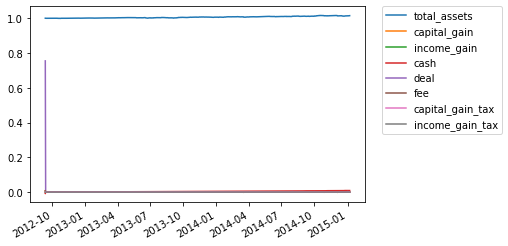

  1%|          | 6/583 [00:00<00:12, 46.67it/s]

                          c         r             q  sharp ratio
3083   [XLF, SHY, LQD, FXI]  0.000044  1.888026e-07   235.488229
3035   [XLF, SHY, GLD, FXI]  0.000044  1.888036e-07   235.105711
3059   [XLF, SHY, AGG, FXI]  0.000044  1.888128e-07   233.761402
3029   [XLF, SHY, GLD, EWT]  0.000042  1.890731e-07   223.001526
3077   [XLF, SHY, LQD, EWT]  0.000042  1.890755e-07   222.960587
3053   [XLF, SHY, AGG, EWT]  0.000042  1.890756e-07   222.963229
12299  [VFH, SHY, LQD, FXI]  0.000044  1.893179e-07   233.823792
12275  [VFH, SHY, AGG, FXI]  0.000044  1.893198e-07   233.281865
12251  [VFH, SHY, GLD, FXI]  0.000044  1.893202e-07   233.250398
12269  [VFH, SHY, AGG, EWT]  0.000042  1.897190e-07   221.908569


100%|██████████| 583/583 [00:07<00:00, 80.89it/s]


[3.16881565e-02 9.68311844e-01 0.00000000e+00 1.30104261e-18]
1.0152529055940855
0.9953143039741336
63


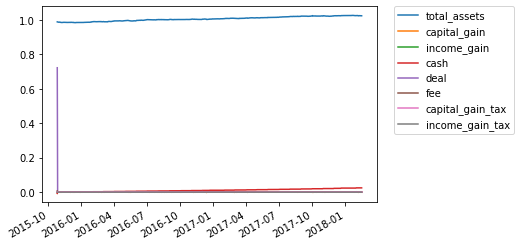

  1%|          | 7/583 [00:00<00:08, 65.86it/s]

                          c         r             q  sharp ratio
12287  [VFH, SHY, AGG, XLP]  0.000006  1.883168e-07    29.369760
12311  [VFH, SHY, LQD, XLP]  0.000006  1.883185e-07    29.563609
12263  [VFH, SHY, GLD, XLP]  0.000006  1.883198e-07    29.736774
12306  [VFH, SHY, LQD, XLE]  0.000006  1.883325e-07    29.651287
12258  [VFH, SHY, GLD, XLE]  0.000006  1.883327e-07    29.678062
12253  [VFH, SHY, GLD, VDE]  0.000006  1.883729e-07    30.433155
12277  [VFH, SHY, AGG, VDE]  0.000006  1.883730e-07    30.488982
12282  [VFH, SHY, AGG, XLE]  0.000006  1.883743e-07    33.545414
12301  [VFH, SHY, LQD, VDE]  0.000006  1.883763e-07    31.351916
12278  [VFH, SHY, AGG, VDC]  0.000006  1.883812e-07    30.952869


100%|██████████| 583/583 [00:07<00:00, 80.29it/s]


[0.00503923 0.98584362 0.         0.00911714]
1.0427530190960952
0.9869601220887515
38


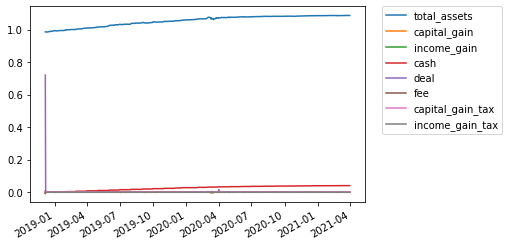

In [8]:
for i in range(len(trains)):
    evaluates = evaluate_combinations(trains[i], cluster, verbose=True)
    del evaluates['w']
    top_10_q = evaluates.sort_values("q").head(10)
    print(top_10_q)
    
    target = evals[i].filter((list(top_10_q['c'])[0]))
    optimizer = MinimumVarianceOptimizer()
    runner = Runner(
        assets=[0.25, 0.25, 0.25, 0.25],
        rebalancer=MonthlyRebalancer(optimizer=optimizer, do_re_optimize=True),
        cash=0
    )

    runner.run(
        market=target,
        train_span=200,
        verbose=True
    )
    report = runner.report()
    print(optimizer.get_weights())
    print(yearly_total_return(report))
    print(max_drawdown(report))
    print(max_drawdown_span(report))
    ax = report.plot()
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    plt.show()